In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob

from skimage import measure
from skimage import filters

from skimage.filters import threshold_otsu
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from csbdeep.utils import _raise, Path, axes_check_and_normalize,axes_dict, move_image_axes, move_channel_for_backend, backend_channels_last
from externalmodels.unet import *
import tensorflow as tf
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE
from stardist import fill_label_holes

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
basedir = '/data/u934/service_imagerie/v_kapoor/Jesus_Segmentation/TestImages/'
basedirResults = '/data/u934/service_imagerie/v_kapoor/Jesus_Segmentation/Results/'
ModelName = 'JesusFilamentSingleChannelUNet'
BaseDir = '/data/u934/service_imagerie/v_kapoor/CurieDeepLearningModels/'

In [7]:
Path = os.path.join(basedir, '*.tif')
X = []
Y = []
Names = []

filesRaw = glob.glob(Path)
maxtime = 0
for fname in filesRaw:
     x = imread(fname)
     X.append(x)
     Names.append(fname)
     if X[0].shape[0] > maxtime:
      maxtime =  X[0].shape[0]  
X.sort
Names.sort
SegmentedLabels = [];
labels = np.array(X[0])
print(labels.shape)
for i in range(len(X)):
    y = np.zeros((maxtime, X[0].shape[1], X[0].shape[2]))
    image = X[i]
    
    y[:X[i].shape[0],:,:] = image[:,:,:]
    Y.append(y) 
Y.sort
axes = 'TYX'
smallaxes = 'YX'
    
print('Total number of images to be segmented = ', len(Y))
print('Image size = ', Y[0].shape)
print('Time dim = ', maxtime )
timerange = maxtime 
count = min(0, len(Y))
print(timerange)




(11, 512, 512)
Total number of images to be segmented =  1
Image size =  (11, 512, 512)
Time dim =  11
11


In [8]:

model  =  CARE(config  =  None,  name  =  ModelName , basedir = BaseDir)
SegmentLabels = []

Loading network weights from 'weights_best.h5'.


In [9]:
def ApplyAll(modelName,img):
      
    

    for j in range(timerange):
      
   
      smallimg = img[j,:,:]
      
      segmented = model.predict(smallimg, smallaxes)
      thresh = segmented.mean()
      binary  =  segmented > thresh
      smalllabels = measure.label(binary, background=0)
      labels [j,:,:] = fill_label_holes(smalllabels[:,:] )
  


        


In [10]:

for  i  in  range(0,  len(Y)):
    
               img = Y[i]
               ApplyAll(ModelName,img)   

        
 

               save_tiff_imagej_compatible((basedirResults + 'Unet' +os.path.basename(Names[i])) , labels, axes)  

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/utils/utils.py:209: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[slices]
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/data/prepare.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[crop]


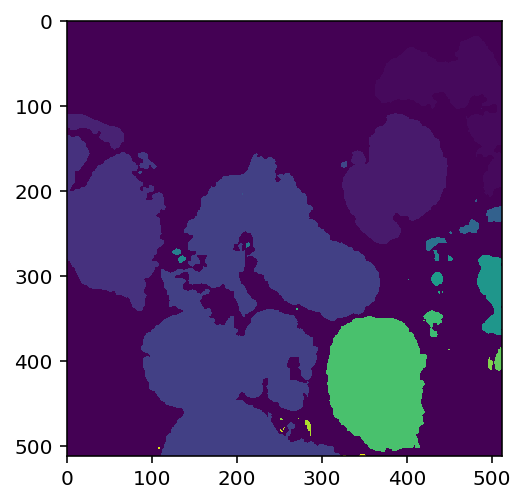

In [11]:
plt.imshow(labels[0,:,:])